# **[Part 2]** Deep Reinforcement Learning

In this notebook we make use of deep Reinforcement Learning, which can be seen as the encounter of Reinforcement Learning (environment, policy, Q-function...) and Deep Learning (neural networks, loss, gradients...)


*Acknowledgement: code is inspired from PyTorch's documentation

# **[Exercice 1]** REINFORCE

In this exercice we are going to implement the REINFORCE algorithm, which is the "simplest" **on-policy** algorithm.


We implement the policy $\pi$ using a deep neural network of parameters $θ$, and we denote it by $\pi_\theta$:

Recall the policy gradient formula (log-trick):

Denoting $\tau = (s_0,a_0, r_0, s_1, a_1 ,r_1, ..., s_{T-1}, a_{T-1},r_{T-1}, s_T)$ a trajectory in the MDP, the objective we aim to optimize is (policy performance):

$$J(θ) = \mathbb{E}_{\tau \sim \pi_θ}[r(\tau)] = ∫_\tau r(\tau)p_θ(\tau)d\tau$$

Where $r(\tau)= \sum_{t\geq 0} \gamma^t r_t$ is the discounted reward associated to the trajectory, and $p_θ(\tau)$ is the probability of the trajectory $\tau$ under the policy $\pi_\theta$, it can be expressed as follows:

$$ p_θ(\tau) = ℙ(s_0) \times \big[ \pi_θ(a_0|s_0) ℙ(r_0 |s_0, a_0)ℙ(s_1|s_0,a_0) \big] \times \big[\pi_θ(a_1|s_1) ℙ(r_1 | s_1, a_1)ℙ(s_2|s_1,a_1)\big] \times …$$

$$p_θ(\tau) = p(s_0) \times \prod_{t= 0}^{T-1} \pi_θ(a_t|s_t)\mathbb{P}(r_t|s_t,a_t)ℙ(s_{t+1}|s_t,a_t) $$

Now, what interests us is the gradient of $J$ with respects to $θ$, because if we know how to compute it, we can optimize J with gradient descent, and get (hope to get) the best policy possible.

To compute this gradient we make use of the log-trick, which is a classical technique to compute gradients of expectactions:

\begin{align*}
∇_θJ(θ) &= ∇_θ \Big[ ∫_\tau r(\tau)p_θ(\tau)d\tau \Big] \\
&= \int_\tau r(\tau) ∇_θp_θ(\tau) d\tau \\
&= \int_\tau r(\tau) ∇_θp_θ(\tau) \times \frac{p_θ(\tau)}{p_θ(\tau)} d\tau \\
&= \int_\tau r(\tau)  \times \frac{∇_θp_θ(\tau)}{p_θ(\tau)} \times p_θ(\tau) d\tau\\
&= \int_\tau r(\tau) ∇_\theta\big[\log(p_\theta)\big](\tau)p_θ(\tau) d\tau\\
&= \mathbb{E}_{\tau \sim \pi_θ}\Big[r(\tau) ∇_\theta\big[\log(p_\theta)\big](\tau)\Big]
\end{align*}

Why are we quite happy with this ? $p_\theta$ is a product, thus taking it's logarithm transforms it into a sum, and sums are quite easy to differentiate:

$$\log(p_\theta(\tau)) = \log(p(s_0)) + \sum_{t=0}^{T-1} \Big[\log (\pi_\theta(a_t|s_t)) + \log(\mathbb{P}(r_t|s_t,a_t)) + \log(ℙ(s_{t+1}|s_t,a_t))  \Big]$$

And when we apply the gradient with respect to θ, most terms disappear and there only remains:

$$ ∇_\theta\big[\log(p_\theta)\big](\tau) = \nabla_θ \log (\pi_θ(a_t | s_t))$$

And we obtain the **Policy Gradient** formula:

$$\nabla_θ J(θ) = \mathbb{E}_{\tau \sim \pi_θ}\Big[\sum_{t=0}^{T-1} \nabla_θ \log (\pi_θ(a_t | s_t)) r(\tau)\Big] $$

Now to get to the REINFORCE formula we will need another trick, I am going to skip the details but you can find them online (e.g. [here](https://web.stanford.edu/class/cs234/slides/lecture7post.pdf)), the idea is to use the temporal structure, and to remark that:

$$\mathbb{E}_{\tau \sim \pi_θ}\Big[ \nabla_θ \log (\pi_θ(a_t | s_t)) r(\tau)\Big] = \mathbb{E}_{\tau \sim \pi_θ}\Big[ \nabla_θ \log (\pi_θ(a_t | s_t))\sum_{t' =t}^{T-1}\gamma^{t'}r_{t'}\Big]$$

And obtain the **REINFORCE** formula:

$$ \nabla_θ J(θ) = \mathbb{E}_{\tau \sim \pi_θ}\Big[\sum_{t=0}^{T-1} \nabla_θ \log (\pi_θ(a_t | s_t)) \sum_{t' =t}^{T-1}\gamma^{t'}r_{t'}\Big]$$



This expectation is hard to compute, but what we can do is estimate it with Monte-Carlo, we generate $N$ trajectories by letting $\pi_θ$ interact with the environment (that is why it is called a on-policy method) and compute the mean:



$$ \nabla_θ J(θ) ≈ \frac{1}{N}\sum_{i=1}^N\Big[\sum_{t=0}^{T-1} \nabla_θ \log (\pi_θ(a_t^{(i)} | s_t^{(i)})) \sum_{t' =t}^{T-1}\gamma^{t'}r_{t'}^{(i)}\Big]$$


That we prefer to write (easier to implement):

$$ \nabla_θ J(θ) ≈ \frac{1}{N}\sum_{i=1}^N\Big[\sum_{t=0}^{T-1} \gamma^t\nabla_θ \log (\pi_θ(a_t^{(i)} | s_t^{(i)})) \sum_{t' =t}^{T-1}\gamma^{t'-t}r_{t'}^{(i)}\Big]$$



And we can now optimize $J$ with gradient descent using our favorite deep learning library.

Note: we will work with $N=1$ in this practical, so it is the case of stochastic gradient descent.


For this TP we are going to use:

- **gym** for the environment part, gym is a popular RL framework introduced by OpenAI, that implements loads of environments.

- **pytorch** for the deep learning part, pytorch is the most popular deep learning library, and is praised for its modulability and ease of use.


In [1]:
#@title Imports
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5) # to have nice looking figs

import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check for GPU

if not torch.cuda.is_available():
  print("No GPU was detected, if you are on Colab, select T4 runtime and reexecute this cell")
  device = torch.device('cpu')
else:
  device = torch.device('cuda:0')

print(device)

No GPU was detected, if you are on Colab, select T4 runtime and reexecute this cell
cpu


### **Environment**: Cartpole

We are going to work with the Cartpole environment, where we learn to balance a pole on a cart

All info on the environment can be found on [gym's documentation](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)


There are two actions in this MDP, push the pole to the left ot to the right, we model it by $\mathcal{A}=\{0, 1\}$.

The state space $\mathcal{S}$ is 4-dimensionnal and continuous.

Our policy will be a neural network that takes as input a vector $s\in ℝ^4$ representing the state and outputs a vector $\pi_\theta(s)\in [0,1]^2$ such that:

$$ \pi_θ(s) = \begin{pmatrix} \pi_θ(\mathrm{left}|s) \\ \pi_θ(\mathrm{right}|s) \end{pmatrix} $$

The episode ends if the pole falls, or if the cart leaves the screen (gone too far on the sides), and we get a reward of 1 for each step taken.



In [2]:
# Load the environment
env = gym.make('CartPole-v1')

The framework of gym is to use the step function:

```
state = env.reset() # Sample initial state

for t in range(T):
  action = policy(state) # Call policy to sample action
  next_state, reward, terminated, truncated = env.step(action) # Act in the environment
  state = next_state
```

Terminated and truncated are here to indicate if the trajectory ends (for example pole falls)



### **Policy**: Multi-Layer Perceptron

For this simple task we implement the policy using a MLP, in other deep RL contexts more complex architectures might be needed (notably CNNs to work with image inputs)


**Question 1.** Implement a MLP with one hidden layer using torch

It should use ReLU as as activation function, and have a dropout regularizer after the first layer.

Finally the last layer should be a SoftMax in order to get probabilities for each action.

In [3]:
class Policy(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
    super().__init__()

    self.fc_1 = nn.Linear(input_dim, hidden_dim)
    self.dropout = nn.Dropout(dropout)
    self.fc_2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      # Apply all the layers to x
      x = self.fc_1(x)
      x = self.dropout(x)
      action_scores = self.fc_2(x)  # Action scores is the output of the last layer
      return F.softmax(action_scores, dim=1) # We pass it through a Softmax to obtain probabilities



# Hint: if you never used pytorch before, the forward function usually looks like this

# def forward(self, x):
#   x= self.first_layer(x)
#   x = F.relu(x)
#   ...
#   return x

In [4]:
# Define some constants that we will use for training
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n

print('Input dimension:', INPUT_DIM)
print('Hidden Dimension:', HIDDEN_DIM)
print('Output dimension:', OUTPUT_DIM)


# Instantiate the policy

policy = Policy(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

# Optimizer, ADAM is a ameliorated version of SGD

optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# Discount_factor

gamma = 0.95



Input dimension: 4
Hidden Dimension: 128
Output dimension: 2


### **Training**

In this part we perform the training of our policy, we will need some utilities.


**Question 2.**  Write a function that takes the list of rewards of a trajectory and computes the sums $\sum_{t' =t}^{T-1}\gamma^{t'-t}r_{t'}$ for all $t$



In [5]:
def calculate_cumulative_returns(rewards):
  returns = []
  R = 0
  T = len(rewards)

  #TODO: Compute the returns list
  for t in range(T-1, -1, -1):
    R = rewards[t] + gamma * R
    returns.insert(0, R)

  # Hint, you can use a for loop from T-1 to 0 instead of 0 to T-1

  # Transform it to tensor

  returns = torch.tensor(returns, device=device)

  return returns


# Hint: we expect that returns[t] = rewards[t] + gamma * rewards[t+1] + ...

**Question 3.** In order to interact for the environment, we need a function that calls the policy in a state, and return the action taken by the policy. To gain some time we also want this function to give us the associated log_probability.

Code: select_action such that select_action(state) returns $a_t = π_θ(s_t)$ and  $\log (\pi_θ(a_t | s_t))$


In [6]:
# Note: to sample random action with respect to the policy probabilities,
# we use torch.distributions instead of numpy.random, because ot will enable us to compute gradients !

def select_action(state):
  state = torch.from_numpy(state).float().unsqueeze(0)  # Little trick to transform the state into a torch Tensor

  action_prob = policy(state)

  dist = distributions.Categorical(action_prob)  # A categorical distribution is a distribution on a finite set

  action = dist.sample() # Sample an action
  log_prob = dist.log_prob(action) # Compute the log probability of the sampled action

  action = action.item() # Transform the action from a Tensor to just its value (i.e. 0 or 1)

  return action, log_prob


**Question 4.** Now we can implement REINFORCE,  let's write a function that in a gym environment, and a value for $\gamma$ and performs a REINFORCE step:

- Generate a trajectory (also called episode in this context) by interacting with the environment

- Compute the REINFORCE formula on this trajectory

- Perform an optimization step (Adam)


Recall we use the formula ($N=1$):

$$ \nabla_θ J(θ) ≈ \sum_{t=0}^{T-1} \gamma^t\nabla_θ \log (\pi_θ(a_t | s_t)) \sum_{t' =t}^{T-1}\gamma^{t'-t}r_{t'}$$

In the usual deep learning framework, we have a loss $\mathcal{L}(θ)$ and we use the "backward" method to automatically compute $∇\mathcal{L}(θ)$ and oerform an optimization step.

Since we're aiming at maximizing $J$, our loss should be:

$$\mathcal{L}(θ) = - \sum_{t=0}^{T-1} \gamma^t \log (\pi_θ(a_t | s_t)) \sum_{t' =t}^{T-1}\gamma^{t'-t}r_{t'}  $$


In [7]:
def reinforce_step():
  rewards = []
  log_probs = []

  policy.train()  # Turns on "training mode" for the network

  state = env.reset()

  for t in range(1000):   # We would want to put while True but is a bad idea to it inside the training of a NN
    action, log_prob = select_action(state)
    # print(action, log_prob)

    next_state, reward, terminated, truncated = env.step(action)
    log_probs.append(log_prob)
    rewards.append(reward)

    state = next_state

    if terminated or truncated:  # It means the episode is over (we reached T)
      break

  returns = calculate_cumulative_returns(rewards)

  # Transform log_probs into a torch object
  log_probs = torch.cat(log_probs).to(device)

  # powers of gamma
  gamma_t = [gamma**t for t in range(len(log_probs))]
  gamma_t = torch.tensor(gamma_t, device=device)

  # Compute the loss
  # print(log_probs.shape)
  # print(gamma_t.shape)
  # print(returns.shape)
  loss = - (log_probs * gamma_t).sum() * returns.sum()

  # Perform the gradient step - torch magic
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # return the value of the loss and trajectory reward so we can make plots

  return loss.item(), sum(rewards)


**Question 5.** Now we can optimize our policy for a given number of reinforce steps, you can play with the parameters to see if you get better results !

In [8]:
env = gym.make('CartPole-v1')
policy = Policy(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)  # You can also play with the learning rate
gamma = 0.99


num_reinforce_steps = 1001 # If you put 1000 it should reach max reward, but if you don't want to take too much time you can put 500, and we'll reach max reward in next questions
losses = []
rewards = []

for step in range(num_reinforce_steps):
  loss, reward = reinforce_step()

  if step % 50 == 0:
    print(f'| Episode: {step:3} | Reward: {reward:5.1f} | ')

  losses.append(loss)
  rewards.append(reward)

| Episode:   0 | Reward:  24.0 | 
| Episode:  50 | Reward:  22.0 | 
| Episode: 100 | Reward:  21.0 | 
| Episode: 150 | Reward:  64.0 | 
| Episode: 200 | Reward:  12.0 | 
| Episode: 250 | Reward:  11.0 | 
| Episode: 300 | Reward:  17.0 | 
| Episode: 350 | Reward:  26.0 | 
| Episode: 400 | Reward:  37.0 | 
| Episode: 450 | Reward:  31.0 | 
| Episode: 500 | Reward:  44.0 | 
| Episode: 550 | Reward:  75.0 | 
| Episode: 600 | Reward: 423.0 | 
| Episode: 650 | Reward:  67.0 | 
| Episode: 700 | Reward:  55.0 | 
| Episode: 750 | Reward:  31.0 | 
| Episode: 800 | Reward:  60.0 | 
| Episode: 850 | Reward:  42.0 | 
| Episode: 900 | Reward:  62.0 | 
| Episode: 950 | Reward:  70.0 | 
| Episode: 1000 | Reward:  56.0 | 


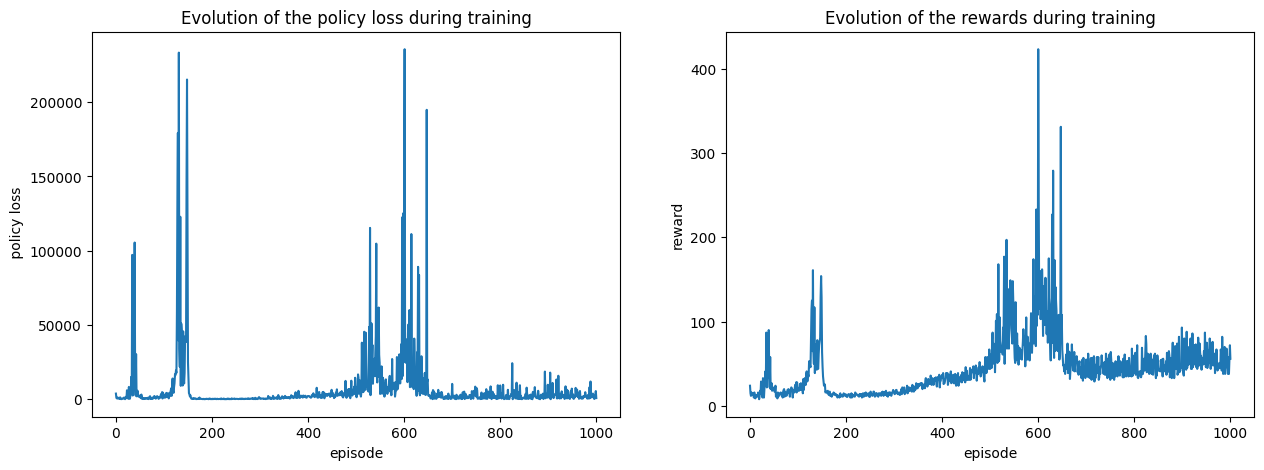

In [9]:
fig, axs = plt.subplots(1,2)

axs[0].plot(losses)
axs[0].set_title("Evolution of the policy loss during training")
axs[0].set_xlabel("episode")
axs[0].set_ylabel(" policy loss")


axs[1].plot(rewards)
axs[1].set_title("Evolution of the rewards during training")
axs[1].set_xlabel("episode")
axs[1].set_ylabel("reward")


plt.show()

As you see training is quite **unstable**, to make the curves more readable, we can plot the average reward on the 25 past episodes.

In [10]:
def compute_average_on_last_episodes(rewards, n_episodes=25):
  mean_rewards = [rewards[0]]
  #TODO:  mean_rewards[i] should contain the average reward between i and i - n_episode
  # Pay attention if i is smaller than n_episode just take the i last episodes
  for i in range(1, len(rewards)):
    j = min(i, 24)
    window = rewards[i-j:i+1]
    mean_rewards.append(np.mean(window))

  return mean_rewards

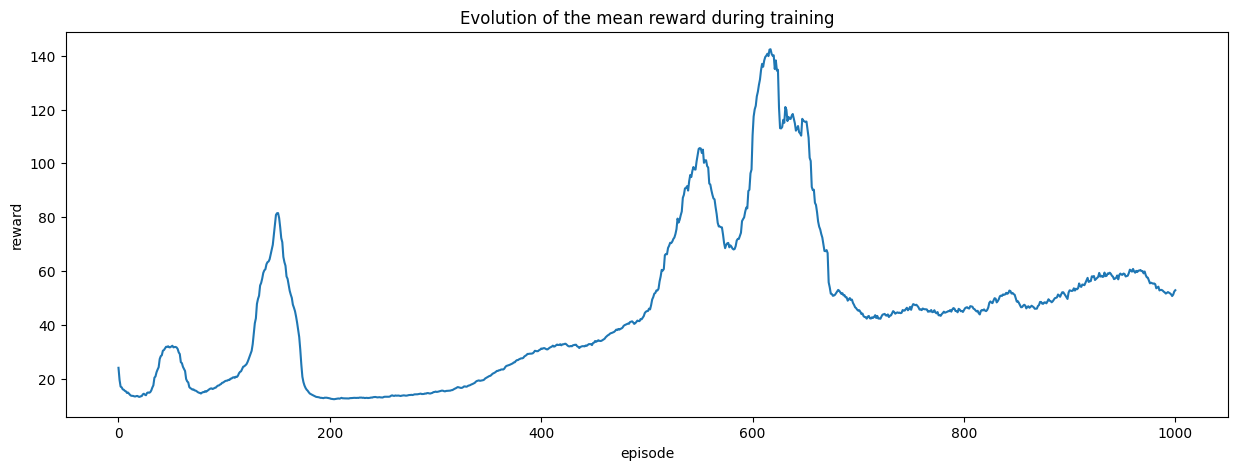

In [11]:
mean_rewards = compute_average_on_last_episodes(rewards, 25)

plt.plot(mean_rewards)
plt.title("Evolution of the mean reward during training")
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()

**Comment**:


On Cartpole the perfect score is 500, we see that our policy was able to reach this score, but because of instability it might fall out of the optima, a strategy is to stop the training when the policy performs good enough (>475) on 25 consecutive episodes.


Also, we are looking at the training reward, but in training our policy is perturbed by the dropout, and the fact it samples its action randomly, what is usually done, is to perform deterministic evals of the policy.


**Question 6.** Write a code that evaluate the deterministic policy, i.e. that plays the action: $a_t = \mathrm{argmax}(\pi_\theta (s_t))$ instead of sampling.

In [ ]:
def evaluate_policy():
  policy.eval()  # put the network in eval mode disables the dropout !
  state = env.reset()
  rewards = []

  for i in range(1000):
    state = torch.tensor(state).unsqueeze(0)

    with torch.no_grad():  # Disable gradients computation
      action_prob = ... # Get the policy's output

    action = ... # Select the most probable action, you might need to use .item() to get a value

    next_state, reward, terminated, truncated = ... # play the action
    state= next_state

    rewards.append(reward)

    if terminated or truncated: break


  return sum(rewards)


In [ ]:
print(f"Our current policy got a reward of {evaluate_policy()} during one evaluation episode")

Now we can train in a proper way:

- Perfom training steps

- Evaluate the policy frequently

- Stop the training when our policy reaches the threshold

In [ ]:
env = gym.make('CartPole-v1')
policy = Policy(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)  # You can also play with the learning rate
gamma = 0.99


reward_treshold = 475
num_episodes_above_threshold = 25

num_reinforce_steps = 1000
losses = []
train_rewards = []
test_rewards = []

for step in range(num_reinforce_steps):
  loss, train_reward = reinforce_step()
  test_reward = evaluate_policy()

  losses.append(loss)
  train_rewards.append(train_reward)
  test_rewards.append(test_reward)

  mean_train_rewards = compute_average_on_last_episodes(train_rewards, n_episodes=num_episodes_above_threshold)
  mean_test_rewards = compute_average_on_last_episodes(test_rewards, n_episodes=num_episodes_above_threshold)

  if mean_test_rewards[-1] > reward_treshold:
    print(f"Reached convegence in {step + 1} episodes")
    break

  if step % 50 == 0:
    print(f'| Episode: {step:3} | Mean train reward: {mean_train_rewards[-1]:5.1f} | Mean test reward: {mean_test_rewards[-1]:5.1f} | ')



In [ ]:
plt.plot(test_rewards, label='Test_reward')
plt.axhline(reward_treshold, color='r', label = 'performance threshold')

plt.xlabel('Episode')
plt.ylabel('Reward')

plt.legend()
plt.show()

And now the best part let's visualize our policy :

##### Video utils (ignore them)

In [ ]:
# Some installations to make it work on colab, I wouldn't recommend to run this on a local jupyter notebook

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
from gym.wrappers.record_video import RecordVideo

%matplotlib inline

import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import os

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env, video_name):
  env = RecordVideo(env, './video')
  return env

##### Visualization

In [ ]:
# Random Policy

# Delete the previous video
!rm -rf video

env = gym.make("CartPole-v1")
state = env.reset()
env = wrap_env(env, 'random_policy')

while True:
  env.render()
  action = env.action_space.sample()

  observation, reward, terminated, truncated = env.step(action)


  if terminated or truncated:
    break

env.close()
show_video()

In [ ]:
# Our Policy

# Delete the previous video
!rm -rf video

env = gym.make("CartPole-v1")
state = env.reset()
env = wrap_env(env, 'random_policy')

policy.eval()

while True:
  env.render()

  state = torch.tensor(state).float().unsqueeze(0)

  #  TODO Play the most probable action as if we're in eval mode
  # Don't forget to put a .item() to change the action to it's value
  action_prob = ...
  action = ...

  next_state, reward, terminated, truncated = ...

  state = next_state


  if terminated or truncated:
    break

env.close()
show_video()